# Imports

In [3]:
%%capture

import math
import db_func
import pandas as pd
import numpy as np
from tqdm import notebook
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, push_notebook, show
import matplotlib.pyplot as plt
#notebook.tqdm(looping)

try:
    %load_ext autotime
    %load_ext jupyterlab_notify
except:
    !pip3 install ipython-autotime
    %load_ext autotime

time: 1.32 s (started: 2021-08-12 22:17:36 -04:00)


## Get Database Connection

In [ ]:
conn = db_func.get_conn()

# Preprocessing

match_df: The final processed dataset to be used in the machine learning models 

## Populate Dataframes From Database

### SQL Query

In [ ]:
match_query = '''SELECT
                    m.match_id,  m.away_id, m.home_id,
                    m.date, m.away_pts, m.home_pts, m.playoff_game,
                    h_ml.home_ml, a_ml.away_ml,
                    h_ps.home_spread, a_ps.away_spread,
                    h_ps.home_ps_odds, a_ps.away_ps_odds,
                    over.over, under.under, ou.spread
                FROM match AS m
                LEFT OUTER JOIN
                (
                    SELECT
                        AVG(decimal_odds) AS home_ml,
                        m.match_id AS match_id
                    FROM
                        odds AS o, team AS t1, team as t2,
                        match AS m
                    WHERE
                        o.bet_type_id = 1 AND
                        o.match_id = m.match_id AND
                        o.team_id = m.home_id
                    GROUP BY m.match_id
                ) AS h_ml ON m.match_id = h_ml.match_id
                LEFT OUTER JOIN
                (
                    SELECT
                        AVG(decimal_odds) AS away_ml,
                        m.match_id AS match_id
                    FROM
                        odds AS o, team AS t1, team as t2,
                        match AS m
                    WHERE
                        o.bet_type_id = 1 AND
                        o.match_id = m.match_id AND
                        o.team_id = m.away_id
                    GROUP BY m.match_id
                ) AS a_ml ON m.match_id = a_ml.match_id
                LEFT OUTER JOIN
                (
                    SELECT
                        AVG(decimal_odds) AS home_ps_odds,
                        AVG(spread) AS home_spread,
                        m.match_id AS match_id
                    FROM
                        odds AS o, team AS t1, team as t2,
                        match AS m
                    WHERE
                        o.bet_type_id = 2 AND
                        o.match_id = m.match_id AND
                        o.team_id = m.home_id
                    GROUP BY m.match_id
                ) AS h_ps ON m.match_id = h_ps.match_id
                LEFT OUTER JOIN
                (
                    SELECT
                        AVG(decimal_odds) AS away_ps_odds,
                        AVG(spread) AS away_spread,
                        m.match_id AS match_id
                    FROM
                        odds AS o, team AS t1, team as t2,
                        match AS m
                    WHERE
                        o.bet_type_id = 2 AND
                        o.match_id = m.match_id AND
                        o.team_id = m.away_id
                    GROUP BY m.match_id
                ) AS a_ps ON m.match_id = a_ps.match_id
                LEFT OUTER JOIN
                (
                    SELECT
                        AVG(decimal_odds) AS under,
                        m.match_id AS match_id
                    FROM
                        odds AS o, match AS m
                    WHERE
                        o.bet_type_id = 3 AND
                        o.over_under = 'under' AND
                        o.match_id = m.match_id
                    GROUP BY m.match_id
                ) AS under ON m.match_id = under.match_id
                LEFT OUTER JOIN
                (
                    SELECT
                        AVG(decimal_odds) AS over,
                        m.match_id AS match_id
                    FROM
                        odds AS o, match AS m
                    WHERE
                        o.bet_type_id = 3 AND
                        o.over_under = 'over' AND
                        o.match_id = m.match_id
                    GROUP BY m.match_id
                ) AS over ON m.match_id = over.match_id
                LEFT OUTER JOIN
                (
                    SELECT
                        AVG(spread) AS spread,
                        m.match_id AS match_id
                    FROM
                        odds AS o, match AS m
                    WHERE
                        o.bet_type_id = 3 AND
                        o.match_id = m.match_id
                    GROUP BY m.match_id
                ) AS ou ON m.match_id = ou.match_id
                WHERE
                    m.date >= DATE('2007-10-30')
                ORDER BY date ASC
                '''

season_query = '''SELECT *
                  FROM season'''
player_performance_query = '''SELECT *
                              FROM player_performance'''
team_query = '''SELECT * 
                FROM team_name'''
injury_query = '''SELECT * 
                FROM injury'''

match_df = pd.read_sql(match_query, conn)
#match_df.set_index('match_id', inplace=True)
season_df = pd.read_sql(season_query, conn)
playerperf_df = pd.read_sql(player_performance_query, conn)
team_df = pd.read_sql(team_query, conn)
injury = pd.read_sql(injury_query, conn)



## Season

Set the season for each match

In [ ]:
def get_season(date):
    return season_df[(season_df['start_date'] <= date) &
                     (season_df['end_date'] >= date)]['season'].values[0]

In [ ]:
match_df['season'] = match_df['date'].map(get_season)

Only matches from seasons 2008-2021 will be used 

# Feature Engineering

## Margin of Victory/Loss (MOVL) with respect to the home team

In [ ]:
match_df['movl'] = match_df['home_pts'] - match_df['away_pts']

## Team Elo Rating

Each team starts at 1500 elo

In [ ]:
match_df['home_elo'] = 1500.0
match_df['away_elo'] = 1500.0

### Get the previous match of each team to aid elo calculation

In [ ]:
def get_prev_match(date, team_id, match_df):
    return match_df[(match_df["date"] < date) &
                    ((match_df["home_id"] == team_id) |
                     (match_df["away_id"] == team_id))].tail(1)

### Team elo calculation

In [ ]:
def get_prev_elo(team_id, season, prev_match):

    if prev_match.empty:
        prev_elo = 1500.0
    elif team_id == prev_match['home_id'].values[0]:
        prev_elo = prev_match['home_elo'].values[0]
    elif team_id == prev_match['away_id'].values[0]:
        prev_elo = prev_match['away_elo'].values[0]
    else: 
        print('err')

    if (not prev_match.empty and
            (prev_match['season'].values[0]
             != season)):
        #print(prev_elo, prev_elo * 0.75 + 1505 * 0.25)
        prev_elo = prev_elo * 0.75 + 1505 * 0.25

    return prev_elo


def update_elo(home_elo, away_elo, movl):
    elo_diff = home_elo + 100.0 - away_elo
    if movl > 0:
        h_s = 1.0
        a_s = 0.0
        multiplier = ((movl+3)**(0.8))/(7.5+0.006*elo_diff)

    else:
        h_s = 0.0
        a_s = 1.0
        multiplier = ((-movl+3)**(0.8))/(7.5+0.006*(-elo_diff))
        
    exp_h_s = 1.0 / (1.0 + 10.0 ** (-elo_diff/400.0))
    exp_a_s = 1.0 - exp_h_s
    
    k = 20.0 * multiplier

    new_home_elo = home_elo + k * (h_s - exp_h_s)
    new_away_elo = away_elo + k * (a_s - exp_a_s)

    return (new_home_elo, new_away_elo)

In [ ]:
for idx, row in match_df.iterrows():
    prev_h_match = get_prev_match(row['date'], row['home_id'], match_df)
    prev_a_match = get_prev_match(row['date'], row['away_id'], match_df)
    
    prev_h_elo = get_prev_elo(
        row['home_id'], row['season'], prev_h_match)
    prev_a_elo = get_prev_elo(
        row['away_id'], row['season'], prev_a_match)    
    
    new_elos = update_elo(prev_h_elo, prev_a_elo, row['movl'])
    match_df.at[idx, 'home_elo'] = new_elos[0]
    match_df.at[idx, 'away_elo'] = new_elos[1]

In [ ]:
def plot_elo(team_id):
    output_notebook()
    plot = figure(title="Historical Elo Rating", x_axis_label="Date", y_axis_label="Elo", 
                  x_axis_type = 'datetime', plot_width=800, plot_height=500)

    y = match_df[(match_df['away_id'] == team_id) | (match_df['home_id'] == team_id)]
    x = y['date']
    y = y.apply(lambda x: x['home_elo'] if x['home_id'] == team_id else x['away_elo'], axis=1)
    
    team_name = team_df[team_df['team_id'] == team_id]['team_name'].head(1).values[0]
    plot.circle(x, y, legend_label = team_name, line_color = 'blue', line_width = 1)

    handle = show(plot, notebook_handle=True)

    # Update the plot title in the earlier cell
    push_notebook(handle=handle)

plot_elo(4)
plot_elo(5)

## Player Efficiency Rating (PER) Sum of Last 5 Games

The Hollinger Player Efficiency Rating for a player is defined as the sum of
the following stats


| Stat | Weight |
| --- | ----------- |
| FGM | 85.910 |
| Steals | 53.897 |
| 3PTM | 51.757 |
| FTM | 46.845 |
| Blocks | 39.190 |
| Offensive Rebounds | 39.190|
| Assists | 34.677 |
| Defensive Rebounds | 14.707 |
| Foul | -17.174 |
| FT Miss | -20.091 |
| FG Miss | -39.190 |
| Turnover | -53.897 |

 divided by (minutes played).

In [ ]:
def player_match_eff_rating(player):
    per = 0
    if player['sp'] > 0:
        per = player['fg'] * 85.910 
        + player['stl'] * 53.897
        + player['threep'] * 51.757
        + player['ft'] * 46.845
        + player['blk'] * 39.190 
        + player['orb'] * 39.190
        + player['drb'] * 34.677
        + player['ast'] * 14.707
        - player['pf'] * 17.174 
        - (player['fta'] - player['ft']) * 20.091 
        - (player['fga'] - player['fg']) * 39.190
        - player['tov'] * 53.897 
        
        per = per / (player['sp']/60.0)
    return per

def team_match_eff_rating(team_id, match_id, playerperf_df):
    df = playerperf_df[(playerperf_df['team_id'] == team_id) &
                        (playerperf_df['match_id'] == match_id)]
    return df['per'].sum()



In [ ]:
### To get head on head matches for an opponent, set opponent_id
def get_prev_matches(date, team_id, match_df, opponent_id = -1):
    if opponent_id == -1:
        return match_df[(match_df["date"] < date) &
                    ((match_df["home_id"] == team_id) |
                     (match_df["away_id"] == team_id))]
    else:
        
        return match_df[(match_df["date"] < date) &
                        (((match_df["home_id"] == team_id) & 
                          (match_df["away_id"] == opponent_id)) |
                         ((match_df["home_id"] == opponent_id) & 
                          (match_df["away_id"] == team_id)) )]

def get_past_per_sum(team_id, prev_matches):
    if len(prev_matches) < 5: 
        return None
    prev_matches['res'] =  prev_matches.apply(lambda x:
                             x['home_per'] if x['home_id'] == team_id
                             else x['away_per'], axis=1)
    return prev_matches['res'].sum()    


In [ ]:
playerperf_df['per'] = playerperf_df.apply(player_match_eff_rating, axis=1)

match_df['away_per'] = match_df.apply(lambda x: team_match_eff_rating(
    x['away_id'],x['match_id'], playerperf_df), axis=1)
match_df['home_per'] = match_df.apply(lambda x: team_match_eff_rating(
    x['home_id'],x['match_id'], playerperf_df), axis=1)

match_df['past_5_home_per'] = match_df.apply(lambda x: 
                                get_past_per_sum(x['home_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['home_id'],
                                                    match_df).tail(5)), axis=1)
match_df['past_5_away_per'] = match_df.apply(lambda x: 
                                get_past_per_sum(x['away_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['away_id'],
                                                    match_df).tail(5)), axis=1)


## BPM 2.0 (BBREF)

### Get team average BPM for past 5 games

In [ ]:
def get_past_bpm_sum(team_id, prev_matches):
    if len(prev_matches) < 5: 
        return None
    prev_matches['res'] =  prev_matches.apply(lambda x:
                             x['home_bpm'] if x['home_id'] == team_id
                             else x['away_bpm'], axis=1)
    return prev_matches['res'].sum()

In [ ]:
match_df['home_bpm'] = match_df.apply(lambda x: 
                        playerperf_df[(playerperf_df['match_id'] == x['match_id']) &
                        (playerperf_df['team_id'] == x['home_id'])]['bpm'].sum(), 
                                      axis=1)
match_df['away_bpm'] = match_df.apply(lambda x: 
                        playerperf_df[(playerperf_df['match_id'] == x['match_id']) &
                        (playerperf_df['team_id'] == x['away_id'])]['bpm'].sum(), 
                                      axis=1)
match_df['past_5_home_bpm'] = match_df.apply(lambda x: 
                                get_past_bpm_sum(x['home_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['home_id'],
                                                    match_df).tail(5)), axis=1)
match_df['past_5_away_bpm'] = match_df.apply(lambda x: 
                                get_past_bpm_sum(x['away_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['away_id'],
                                                    match_df).tail(5)), axis=1)

## Defensive Rating (DRTG)

In [ ]:
def get_past_drtg_sum(team_id, prev_matches):
    if len(prev_matches) < 5: 
        return None
    prev_matches['res'] =  prev_matches.apply(lambda x:
                             x['home_drtg'] if x['home_id'] == team_id
                             else x['away_drtg'], axis=1)
    return prev_matches['res'].sum()

In [ ]:
match_df['home_drtg'] = match_df.apply(lambda x: 
                        playerperf_df[(playerperf_df['match_id'] == x['match_id']) &
                        (playerperf_df['team_id'] == x['home_id'])]['drtg'].sum(), 
                                      axis=1)
match_df['away_drtg'] = match_df.apply(lambda x: 
                        playerperf_df[(playerperf_df['match_id'] == x['match_id']) &
                        (playerperf_df['team_id'] == x['away_id'])]['drtg'].sum(), 
                                      axis=1)

match_df['past_5_home_drtg'] = match_df.apply(lambda x: 
                                get_past_drtg_sum(x['home_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['home_id'],
                                                    match_df).tail(5)), axis=1)
match_df['past_5_away_drtg'] = match_df.apply(lambda x: 
                                get_past_drtg_sum(x['away_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['away_id'],
                                                    match_df).tail(5)), axis=1)

In [ ]:
def get_past_pts_sum(team_id, prev_matches):
    if len(prev_matches) < 5: 
        return None
    prev_matches['res'] =  prev_matches.apply(lambda x:
                             x['home_pts'] if x['home_id'] == team_id
                             else x['away_pts'], axis=1)
    return prev_matches['res'].sum()

In [ ]:
match_df['past_5_home_pts'] = match_df.apply(lambda x: 
                                get_past_pts_sum(x['home_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['home_id'],
                                                    match_df).tail(5)), axis=1)
match_df['past_5_away_pts'] = match_df.apply(lambda x: 
                                get_past_pts_sum(x['away_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['away_id'],
                                                    match_df).tail(5)), axis=1)

# Exploratory Data Analysis

## Feature Correlation Matrix

In [ ]:
match_df = match_df[(match_df['past_5_home_bpm'].notnull()) &
                   (match_df['past_5_away_bpm'].notnull())]

In [ ]:
features = ['home_elo', 'away_elo', 
            'past_5_home_bpm', 'past_5_away_bpm', 
            'past_5_home_per', 'past_5_away_per',
            'past_5_home_drtg', 'past_5_away_drtg',
            'past_5_home_pts', 'past_5_away_pts',
            'home_ml', 'away_ml']
corr_df = match_df[features]

corr = corr_df.corr()
corr.style.background_gradient(cmap='coolwarm')

# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

Remove all rows where there were not enough games yet to calculate past 5 bpm/per

## Save Final Dataset into CSV

In [ ]:
match_df.to_csv('nba_data.csv', header=True, index=False)

# Machine Learning Models

# Splitting into Training and Test Sets

## Simple 80/20 split

In [6]:
import pandas as pd
import numpy as np
match_df = pd.read_csv('nba_data.csv')

features = ['home_elo', 'away_elo', 
            'past_5_home_bpm', 'past_5_away_bpm', 
            'past_5_home_per', 'past_5_away_per',
            'past_5_home_drtg', 'past_5_away_drtg',
            'past_5_home_pts', 'past_5_away_pts',
            'home_ml', 'away_ml']

# match_df = match_df[features]
#match_df.dropna(inplace=True)


match_df['home_win'] = match_df['movl'].map(lambda x: 0 if x < 0 else 1)

cutoff = math.floor(len(match_df) * 0.8)
train = match_df[match_df.index < 14202]
test = match_df[match_df.index >= 14202]




## Check for Nan's and inf's
# print(f"Has Nan's: {np.any(np.isnan(train))}")
# print(train[train.isna().any(axis=1)])
# print(train.index[np.isinf(train).any(1)])
# print(f"Has infinites: {np.all(np.isfinite(train))}")



time: 63.1 ms (started: 2021-08-12 22:25:15 -04:00)


## XGBoost

In [7]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

X_train = train[features]
X_test = test[features]

y_train = train['movl']
y_test = test['movl']

data_dmatrix = xgb.DMatrix(data=X_train, label = y_train)

time: 16.6 ms (started: 2021-08-12 22:25:18 -04:00)


In [9]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=24, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

time: 182 ms (started: 2021-08-12 22:26:18 -04:00)


In [10]:
preds = xg_reg.predict(X_test)

time: 16.6 ms (started: 2021-08-12 22:26:21 -04:00)


In [11]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
rmse

13.134410825186935

time: 1.89 ms (started: 2021-08-12 22:26:21 -04:00)


In [12]:
#df = pd.DataFrame(, columns=['movl','xgb_movl'], axis = 1)
preds = pd.Series(preds, name='xgb_movl')
df = pd.concat([y_test.reset_index(drop=True), 
                preds.reset_index(drop=True),
               test['home_ml'].reset_index(drop=True),
               test['away_ml'].reset_index(drop=True)], axis=1)

time: 2.02 ms (started: 2021-08-12 22:26:22 -04:00)


In [13]:
df['home_win'] = df['movl'].map(lambda x: 0 if x < 0 else 1)
df['xgb_home_win'] = df['xgb_movl'].map(lambda x: 0 if x < 0 else 1)

time: 3.51 ms (started: 2021-08-12 22:26:23 -04:00)


In [14]:
df['correct_pred'] = df.apply(lambda x: 
    1 if x['home_win'] == x['xgb_home_win'] else 0, axis = 1)

time: 20.6 ms (started: 2021-08-12 22:26:25 -04:00)


In [15]:
acc = df['correct_pred'].sum()/len(df.index)
acc

0.6825218125527723

time: 1.52 ms (started: 2021-08-12 22:26:25 -04:00)


In [ ]:
import matplotlib.pylab as pl
xgb.plot_importance(xg_reg)
pl.title("xgboost.plot_importance(model)")
pl.show()

## Accuracy of using just ML

In [16]:
df['ml_pred'] = df.apply(lambda x: 
    1 if x['home_ml'] < x['away_ml'] else 0, axis = 1)

df['ml_correct_pred'] = df.apply(lambda x: 
    1 if x['home_win'] == x['ml_pred'] else 0, axis = 1)

acc = df['ml_correct_pred'].sum()/len(df.index)
acc

0.6681677455671263

time: 53.4 ms (started: 2021-08-12 22:26:31 -04:00)


## Tuning XGBoost

In [17]:
# for train_index, test_index in tscv.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y[train_index], y[test_index]


time: 219 µs (started: 2021-08-12 22:26:32 -04:00)


### TimeSeriesSplit

In [18]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.metrics import mean_squared_error


tscv = TimeSeriesSplit(n_splits=5)
print(tscv)

xgb_model = xgb.XGBRegressor()

match_df = pd.read_csv('nba_data.csv')

features = ['home_elo', 'away_elo', 
            'past_5_home_bpm', 'past_5_away_bpm', 
            'past_5_home_per', 'past_5_away_per',
            'past_5_home_drtg', 'past_5_away_drtg',
            'past_5_home_pts', 'past_5_away_pts',
            'home_ml', 'away_ml']

# match_df = match_df[features]
#match_df.dropna(inplace=True)


match_df['home_win'] = match_df['movl'].map(lambda x: 0 if x < 0 else 1)

cutoff = math.floor(len(match_df) * 0.8)
train = match_df[match_df.index < 14202]
test = match_df[match_df.index >= 14202]

X_train = train[features]
X_test = test[features]

y_train = train['movl']
y_test = test['movl']




TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
time: 55.5 ms (started: 2021-08-12 22:26:36 -04:00)


In [27]:
params = {
        'min_child_weight': [5, 7, 9, 11, 13],
        'gamma': [0.05, 0.1, 0.25, 0.5, 0.75],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 7, 9],
        'n_estimators': range(50,200,50),
        'random_state' = 1,
    
        }
grid_search = GridSearchCV(estimator = xgb_model, 
                           cv = tscv, 
                           scoring = 'neg_root_mean_squared_error',
                           param_grid = params)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         '

time: 10h 43min 56s (started: 2021-08-12 23:28:38 -04:00)


### GridsearchCV

In [28]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_search.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_search.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_search.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0.05, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=9, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=24, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

 The best score across ALL searched params:
 -11.66359783109638

 The best parameters across ALL searched params:
 {'colsample_bytree': 1.0, 'gamma': 0.05, 'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 50, 'subsample': 1.0}
time: 2.82 ms (started: 2021-08-13 12:58:56 -04:00)


In [30]:
cv_preds = grid_search.best_estimator_.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, cv_preds))
print(f'RMSE: {rmse}')

df['xgbcv_movl'] = cv_preds
df['xgbcv_home_win'] = df['xgbcv_movl'].map(lambda x: 0 if x < 0 else 1)
df['correct_cv_pred'] = df.apply(lambda x: 
     1 if x['home_win'] == x['xgbcv_home_win'] else 0, axis = 1)
acc = df['correct_cv_pred'].sum()/len(df.index)
acc

RMSE: 12.697496494392666


0.6943428088938924

time: 33.9 ms (started: 2021-08-13 13:01:34 -04:00)


### Save tuned model

In [46]:
import pickle
file_name = "xgb_reg.pkl"
# save
pickle.dump(grid_search.best_estimator_, open(file_name, "wb"))

# load
xgb_model_loaded = pickle.load(open(file_name, "rb"))

RMSE: 12.697496494392666


0.6943428088938924

time: 40.5 ms (started: 2021-08-13 13:17:22 -04:00)


NameError: name 'pl' is not defined

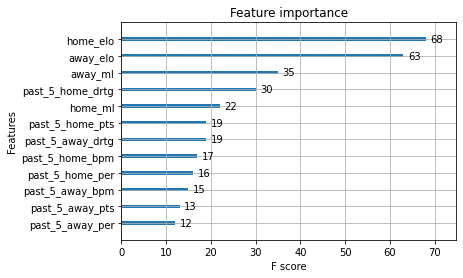

time: 124 ms (started: 2021-08-13 13:18:24 -04:00)


In [47]:
xgb.plot_importance(xgb_model_loaded)
pl.title("xgboost.plot_importance(model)")
pl.show()

In [ ]:
for train_index, test_index in tscv.split(X_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]


In [ ]:
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics

X_train = X_train.dropna()
X_train = train[features]
X_test = test[features]

y_train = train['home_win']
y_test = test['home_win']

lr_model = LogisticRegression(random_state=1)
lr_model.fit(X_train, y_train)

print(metrics.accuracy_score(y_test, y_pred))